In [1]:
import model.VQVAE
from timm.models import create_model

model = create_model(
    'vqkd_encoder_base_decoder_9x768x12_pixel',
    pretrained = True,
    pretrained_weight = '/mnt/lustre/zhengjinliang/vision-language-model/VQ-VAE/exp/pixel_reconstruction_larger/log/checkpoint-139.pth',
    as_tokenzer = True,
    n_code = 16384
)

{}
Final encoder config {'img_size': 224, 'patch_size': 16, 'in_chans': 3, 'num_classes': 0, 'embed_dim': 768, 'depth': 12, 'num_heads': 12, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.0, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'init_values': 0.0, 'use_abs_pos_emb': True, 'use_rel_pos_bias': False, 'use_shared_rel_pos_bias': False, 'use_mean_pooling': True, 'init_scale': 0.001}
Final decoder config {'img_size': 14, 'patch_size': 1, 'in_chans': 32, 'num_classes': 0, 'embed_dim': 768, 'depth': 9, 'num_heads': 12, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.0, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'init_values': 0.0, 'use_abs_pos_emb': True, 'use_rel_pos_bias': False, 'use_shared_rel_pos_bias': False, 'use_mean_pooling': True, 'init_scal

In [2]:
from dataset import build_imagenet_for_vqvae
from easydict import EasyDict
from PIL import Image
import matplotlib.pyplot as plt
data_args = EasyDict(
    dict(
        color_jitter = 0.4,
        input_size = 224,
        min_crop_scale = 0.08,
        train_interpolation = 'bicubic',
        root_dir_train='/mnt/lustre/share/images/train/',
        root_dir_val = '/mnt/lustre/share/images/val/',
        meta_file_train= '/mnt/lustre/share/images/meta/train.txt',
        meta_file_val= '/mnt/lustre/share/images/meta/val.txt'
    )
)
dataset = build_imagenet_for_vqvae(False, data_args)
train_dataset = build_imagenet_for_vqvae(True, data_args)


/mnt/cache/share/spring/conda_envs/miniconda3/envs/s0.3.4/lib/python3.6/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/mnt/cache/share/spring/conda_envs/miniconda3/envs/s0.3.4/lib/python3.6/site-packages/torchvision/transforms/transforms.py:804: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Test Data Aug: Compose(
    Resize(size=256, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    ToTensor()
)
Train Data Aug: Compose(
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


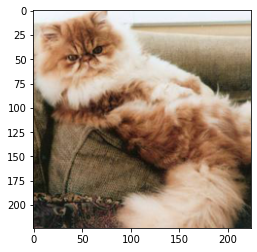

In [19]:
img, label = dataset[129]
pre_img = img.unsqueeze(0)
# pre_img = model.pre_process(input_img)
pre_img = pre_img.squeeze().permute(1,2,0)
plt.imshow(pre_img)

torch.Size([1, 32, 14, 14])
torch.Size([1, 3, 224, 224])
(tensor(0.0241, grad_fn=<AddBackward0>), {'train/quant_loss': tensor(0.0030), 'train/rec_loss': tensor(0.0210), 'train/total_loss': tensor(0.0241)})


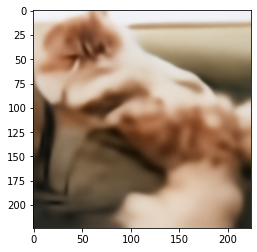

In [20]:
input_img = img.unsqueeze(0)
quantize, embed_ind, emb_loss = model.encode(input_img)
print(quantize.shape)
output = model.decode(quantize)
out_img = model.unpatchify(output)
print(out_img.shape)
out_img = out_img.squeeze().permute(1, 2, 0).detach().numpy()
plt.imshow(out_img)
print(model(input_img))

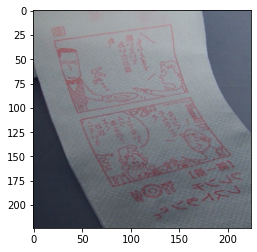

In [11]:
img, label = train_dataset[-22]
pre_img = img.unsqueeze(0)
# pre_img = model.pre_process(input_img)
pre_img = pre_img.squeeze().permute(1,2,0)
plt.imshow(pre_img)

torch.Size([1, 32, 14, 14])
torch.Size([1, 3, 224, 224])
(tensor(0.0821, grad_fn=<AddBackward0>), {'train/quant_loss': tensor(0.0004), 'train/rec_loss': tensor(0.0817), 'train/total_loss': tensor(0.0821)})


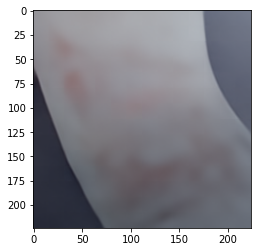

In [12]:
input_img = img.unsqueeze(0)
quantize, embed_ind, emb_loss = model.encode(input_img)
print(quantize.shape)
output = model.decode(quantize)
out_img = model.unpatchify(output)
print(out_img.shape)
out_img = out_img.squeeze().permute(1, 2, 0).detach().numpy()
plt.imshow(out_img)
print(model(input_img))

In [61]:
import random
from torchvision.transforms import ToPILImage as unloader
length = len(train_dataset)
for i in random.sample(range(length), 20):
    img, label = train_dataset[i]
    pre_img = img.unsqueeze(0)
    # pre_img = model.pre_process(input_img)
    pre_img = pre_img.squeeze()
    pre_img = unloader()(pre_img)
    pre_img.save(f'output/trainset/{i}_target.jpg')
    input_img = img.unsqueeze(0)
    quantize, embed_ind, emb_loss = model.encode(input_img)
    output = model.decode(quantize)
    out_img = model.unpatchify(output)
    out_img = out_img.squeeze().detach()
    out_img = unloader()(out_img)
    out_img.save(f'output/trainset/{i}generate.jpg')

In [59]:
import random
from torchvision.transforms import ToPILImage as unloader
length = len(dataset)
for i in random.sample(range(length), 10):
    img, label = dataset[i]
    pre_img = img.unsqueeze(0)
    # pre_img = model.pre_process(input_img)
    pre_img = pre_img.squeeze()
    pre_img = unloader()(pre_img)
    pre_img.save(f'output/valset/{i}_target.jpg')
    input_img = img.unsqueeze(0)
    quantize, embed_ind, emb_loss = model.encode(input_img)
    output = model.decode(quantize)
    out_img = model.unpatchify(output)
    out_img = out_img.squeeze().detach()
    out_img = unloader()(out_img)
    out_img.save(f'output/valset/{i}generate.jpg')